In [147]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
import random
import pickle
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [148]:
warnings.filterwarnings('ignore')

In [149]:
# len(weights_ann_1[0].ravel())

In [150]:
def get_targets_with_weights(batch_data, initial_ensembles, size_ens): 
    
    target_dim = 1
    
    # weights_ann_1 = ann.get_weights()
    
    # h1  = ann.layers[1].output.shape[-1]

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [151]:
def ann(hidden = 32, input_shape = 256, output_shape = 1): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(output_shape, activation = "relu")
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [152]:
def generate_initial_ensembles(num_weights, lambda1, size_ens):
    mean_vec = np.zeros((num_weights,))
    cov_matrix = lambda1*np.identity(num_weights)
    mvn_samp = mvn(mean_vec, cov_matrix)
    return mvn_samp.rvs(size_ens)

In [153]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [154]:
samp_ann =  ann(hidden = 16, input_shape = 32, output_shape = 1)

In [155]:
weights_ann_1 = samp_ann.get_weights()

In [156]:
h1  = samp_ann.layers[1].output.shape[-1]

In [157]:
h1

16

In [158]:
samp_ann.count_params()

545

In [159]:
hidden_neurons = h1

In [160]:
samp_ann_params = samp_ann.count_params()

In [161]:
def get_initial_X_t(data1, data2, data3, data4, size_ens, var_weights = 1.0, var_weight_weights = 4.0, var_L = 1.0, var_D = 1.0):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    
    initial_ensembles1 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out1, data1_stack1 = get_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens)
    
    initial_ensembles2 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data1_out2, data1_stack2 = get_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens)
    
    initial_ensembles3 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data2_out1, data2_stack1 = get_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens)
    
    initial_ensembles4 = generate_initial_ensembles(samp_ann_params, var_weights, size_ens)
    data2_out2, data2_stack2 = get_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles_for_weights = generate_initial_ensembles(4, var_weight_weights, size_ens)
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = generate_initial_ensembles(4, var_L, size_ens)
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)    
    
    initial_ensembles_for_D1 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    # initial_ensembles_for_D2 = generate_initial_ensembles(1, var_D, size_ens).reshape(-1,1)
    
    initial_ensembles_for_D1_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    initial_ensembles_for_D2_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
    initial_ensembles_for_D3_zero = np.zeros((size_ens,1,1)).reshape(-1,1)
    
    initial_ensembles_for_D = np.concatenate((np.expand_dims(initial_ensembles_for_D1,1),
                                                       np.expand_dims(initial_ensembles_for_D1_zero,1), 
                                                      np.expand_dims(initial_ensembles_for_D2_zero,1),
                                                       np.expand_dims(initial_ensembles_for_D3_zero,1)), axis = 2)
    
    # print(X_t.shape, initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4))
    
    return X_t, initial_ensembles, initial_ensembles_for_weights[:,0,:], initial_ensembles_for_D[:,0,:]

In [162]:
def get_weighted_targets_with_weights(batch_data, initial_ensembles, size_ens, weights): 
    
    target_dim = 1
    

    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1
    
    final_output_1 = final_output_1[:,:, 0]
    
    final_output_1 = final_output_1*weights
    
    # print(final_output_1.shape, initial_ensembles.shape)
    
    stack = np.hstack((final_output_1, initial_ensembles))

    
    return final_output_1, stack

In [163]:
from scipy.stats import beta

In [164]:
fudging_beta = beta(1,9)

In [165]:
def forward_operation(data1, data2, data3, data4, combined_ensembles , size_ens, fudging_beta):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (4*params):(4*params + 4)]
    
    # initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(4*params + 4):(4*params + 4 + 4 )]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    # +  fudging_beta.rvs(size_ens).reshape(-1,1)
    
    model_1 = softmax_weights[:, 0].reshape(-1,1) 
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1].reshape(-1,1) 
    
    model_3 = softmax_weights[:, 2].reshape(-1,1) 
    
    model_4 = softmax_weights[:, 3].reshape(-1,1)
    
    sum_weights = model_1 + model_2 + model_3 + model_4
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
    model_3 = model_3/sum_weights
    
    model_4 = model_4/sum_weights
    
    
    # print(np.mean(model_1 + model_2))
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
    data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
                                                                 weights=model_3)
    
    data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
                                                                  weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4, 
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2 + data2_out1 + data2_out2
    
    # weighted_psa = data1_out2 + data2_out2
    
    return X_t, initial_ensembles,final_output, model_1, model_2, model_3, model_4

In [166]:
def forward_operation_test(data1, data2, data3, data4, combined_ensembles , size_ens):
    # samp_ann =  ann(hidden = hidden_neurons, input_shape = 32, output_shape = 1)
    params = samp_ann_params
    initial_ensembles1 = combined_ensembles[:, :params]
    initial_ensembles2 = combined_ensembles[:, params:(2*params)]
    initial_ensembles3 = combined_ensembles[:, (2*params):(3*params)]
    initial_ensembles4 = combined_ensembles[:, (3*params):(4*params)]

    
    initial_ensembles_for_weights = combined_ensembles[:, (4*params):(4*params + 4)]
    
    # initial_ensembles_for_L = combined_ensembles[:, (4*params + 4):(4*params + 4 + 4)]
    
    initial_ensembles_for_D = combined_ensembles[:,(4*params + 4):(4*params + 4 + 4)]
    
    
    softmax_weights = tf.math.softmax(initial_ensembles_for_weights).numpy()
    
    model_1 = softmax_weights[:, :1].reshape(-1,1)
    
    # model_1 = np.min(model_1 -fudging_factor)
    
    model_2 = softmax_weights[:, 1:2].reshape(-1,1) 
    
    model_3 = softmax_weights[:, 2:3].reshape(-1,1) 
    
    model_4 = softmax_weights[:, 3:4].reshape(-1,1)
    
    sum_weights = model_1 + model_2 + model_3 + model_4
    
    
    # model_1_plus_model_2 = model_1 + model_2
    
    model_1 = model_1/sum_weights
    
    model_2 = model_2/sum_weights
    
    model_3 = model_3/sum_weights
    
    model_4 = model_4/sum_weights
    
    data1_out1, data1_stack1 = get_weighted_targets_with_weights(data1, initial_ensembles1, size_ens = size_ens,
                                                                  weights=model_1)
    
    data1_out2, data1_stack2 = get_weighted_targets_with_weights(data2, initial_ensembles2, size_ens = size_ens,
                                                                weights=model_2)
    
    data2_out1, data2_stack1 = get_weighted_targets_with_weights(data3, initial_ensembles3, size_ens = size_ens,
                                                                 weights=model_3)
    
    data2_out2, data2_stack2 = get_weighted_targets_with_weights(data4, initial_ensembles4, size_ens = size_ens,
                                                                  weights=model_4)   
    
    X_t = np.concatenate((np.expand_dims(data1_stack1, -1), np.expand_dims(data1_stack2, -1), 
                         np.expand_dims(data2_stack1, -1), np.expand_dims(data2_stack2, -1)), axis = -1)
    
    initial_ensembles = np.hstack((initial_ensembles1, initial_ensembles2, initial_ensembles3, initial_ensembles4, 
                        initial_ensembles_for_weights, initial_ensembles_for_D))
    
    # print(X_t.shape)
    
    initial_ensembles_for_weights = np.expand_dims(initial_ensembles_for_weights,1)
    
    # initial_ensembles_for_L = np.expand_dims(initial_ensembles_for_L,1)
    
    initial_ensembles_for_D = np.expand_dims(initial_ensembles_for_D,1)
    
    # print(initial_ensembles_for_weights.shape)
    
    X_t = np.concatenate((X_t, initial_ensembles_for_weights, initial_ensembles_for_D), axis = 1)
    
    final_output = data1_out1 + data1_out2 + data2_out1 + data2_out2
    
    return X_t, initial_ensembles, final_output, model_1, model_2, model_3, model_4

In [167]:
samp_ann.count_params()

545

In [168]:
total_weights = 4*(samp_ann.count_params() + 1 + 1)

In [169]:
# 4*(samp_ann.count_params()) + 1 + 1

In [170]:
# total_weights

In [171]:
reduction = 10

In [172]:
size_ens = total_weights//reduction

In [173]:
size_ens

218

In [174]:
G_t = [[1, 1, 1, 1]]
G_t = np.array(G_t).T

In [175]:
G_t.shape

(4, 1)

In [176]:
def get_predictions(data1, data2, data3, data4, initial_ensembles, fudging_beta  =fudging_beta): 
    _,_, weighted_alogp, w1, w2, w3, w4 = forward_operation(data1, data2, data3, data4, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    return weighted_alogp, w1, w2, w3, w4

In [177]:
def get_predictions_test(data1, data2, data3, data4, initial_ensembles): 
    _,_, weighted_alogp, w1, w2, w3, w4 = forward_operation_test(data1, data2, data3, data4, initial_ensembles, size_ens = size_ens)
    return weighted_alogp, w1, w2, w3, w4

In [178]:
def calculate_mu_bar_G_bar(data1, data2, data3, data4, initial_ensembles, fudging_beta):
    H_t = np.hstack((np.identity(data1.shape[0]), np.zeros((data1.shape[0], samp_ann_params + 1  + 1))))
    mu_bar = initial_ensembles.mean(0)
    X_t, _,_, _, _, _, _ = forward_operation(data1, data2, data3, data4, initial_ensembles, size_ens = size_ens, fudging_beta = fudging_beta)
    X_t = X_t.transpose((0,2,1))
    X_t = X_t.reshape(X_t.shape[0], X_t.shape[1]*X_t.shape[2])
    script_H_t = np.kron(G_t.T, H_t)
    G_u = (script_H_t@X_t.T)
    G_u = G_u.T
    G_bar = (G_u.mean(0)).ravel()
    return mu_bar.reshape(-1,1), G_bar.reshape(-1,1), G_u

In [179]:
def calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u): 
    u_j_minus_u_bar = initial_ensembles - mu_bar.reshape(1,-1)
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    c = np.zeros((total_weights, G_bar.shape[0]))
    for i in range(0, size_ens): 
        c += np.kron(u_j_minus_u_bar[i, :].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return c/size_ens, G_u_minus_G_bar

In [180]:
def calculate_D_u( G_bar, G_u): 
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    d = np.zeros((G_bar.shape[0], G_bar.shape[0]))
    for i in range(0, size_ens): 
        d += np.kron(G_u_minus_G_bar[i,:].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return d/size_ens

In [181]:
def get_updated_ensemble(data1, data2, data3, data4, initial_ensembles, y_train, size_ens = size_ens, inflation_factor = 1.0, fudging_beta = fudging_beta, 
                        fudging_var = None):
    mu_bar, G_bar, G_u = calculate_mu_bar_G_bar(data1, data2, data3, data4, initial_ensembles, fudging_beta)
    C, G_u_minus_G_bar = calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u)
    D = calculate_D_u( G_bar, G_u)
    _, R_t = create_cov(data1.shape[0],initial_ensembles)
    inflation = np.identity(R_t.shape[0])*inflation_factor
    D_plus_cov = D + (R_t *inflation_factor)
    D_plus_cov_inv = np.linalg.inv(D_plus_cov)
    mid_quant = C@D_plus_cov_inv
    noise_vec_mean = np.zeros((R_t.shape[0], ))
    noise_mvn = mvn(noise_vec_mean, R_t)
    fudging = noise_mvn.rvs(size_ens)
    interim = (y_train.T.flatten().reshape(1,-1) + fudging)
    right_quant = interim - G_u
    mid_times_right = mid_quant@right_quant.T
    updated_ensemble = (initial_ensembles + mid_times_right.T)
    if fudging_var is not None: 
        mean_vec = np.zeros((updated_ensemble.shape[1],))
        cov_mat = np.identity(updated_ensemble.shape[1])*fudging_var
        fudging_for_updated_ensembles = mvn(mean_vec, cov_mat)
        fudging_for_updated_ensembles_vec = fudging_for_updated_ensembles.rvs(size_ens)
        updated_ensemble = updated_ensemble + fudging_for_updated_ensembles_vec
    return updated_ensemble

In [182]:
target_dim = 1

In [183]:
lambda_D = 1

In [184]:
from joblib import Parallel, delayed

In [185]:
def create_cov(shape, initial_ensembles):
    cov_part = initial_ensembles[:, -4:-3]
    cov_part = cov_part.mean(0)
    variances1 = tf.math.softplus(cov_part).numpy()
    n = shape
    return variances1, np.identity(n)*variances1

In [186]:
# idx = 1

In [187]:
with open("..//Data//gcn_cdr_train_pca.pickle", "rb") as f: 
    catch_train = pickle.load(f)

In [188]:
with open("..//Data//gcn_cdr_test_pca.pickle", "rb") as f: 
    catch_test = pickle.load(f)

In [189]:
import random

In [190]:
def prepare_data_train(catch_train, size): 
    idxes = random.sample(range(0, catch_train[0].shape[0]), k = size)
    idxes = list(idxes)
    data1, data2, data3, data4 = catch_train[0][idxes,:], catch_train[1][idxes,:], catch_train[2][idxes,:], catch_train[3][idxes,:]
    
    y_train = catch_train[-1][idxes].reshape(-1,1)
    
    return data1, data2, data3, data4, y_train 

In [191]:
def prepare_data_test( catch_test, size): 
    idxes = random.sample(range(0, catch_test[0].shape[0]), k = size)
    idxes = list(idxes)
    data1, data2, data3, data4 = catch_test[0][idxes,:], catch_test[1][idxes,:], catch_test[2][idxes,:], catch_test[3][idxes,:]
    y_train = catch_test[-1][idxes].reshape(-1,1)
    return data1, data2, data3, data4, y_train

In [192]:
# data1_train, data2_train, data3_train, data4_train, y_train =  prepare_data_train(catch_train, size = 2500)

In [193]:
# data1_test, data2_test, data3_test, data4_test, y_test =  prepare_data_test(catch_test, size = 1000)

In [194]:
from scipy.stats import pearsonr

In [195]:
def get_results(idx, var_weights = 1.0, var_weight_weights = 4.0, var_D = 1, inflation_factor = 1.6, fudging_beta = beta(1,19), 
               fudging_var = 1e-3, epochs = 30):
    
    # smiles_feats_train, rdkit_feats_train, smiles_feats_valid, rdkit_feats_valid, y_train, y_train_actual, y_valid, y_valid_actual, initial_ensembles  = prepare_data(idx, var_weights = var_weights, var_weight_weights =var_weight_weights, var_L = var_L, var_D = var_D)
    
    
    data1_train, data2_train, data3_train, data4_train, y_train =  prepare_data_train(catch_train, size = 2500)
    
    data1_test, data2_test, data3_test, data4_test, y_test =  prepare_data_test(catch_test, size = 1000)
    
    X_t, initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D = get_initial_X_t(data1_train, data2_train, data3_train, data4_train,
                                                                                                 size_ens = size_ens, var_weights = var_weights,
                                                                                                var_weight_weights = var_weight_weights, var_D = var_D)
    
    initial_ensembles = np.hstack((initial_ensembles, initial_ensembles_for_weights, initial_ensembles_for_D))
    
    best_rmse_train = 100000
    
    for i in range(0,epochs):
        print("epoch number is " +str(i))

        initial_ensembles = get_updated_ensemble(data1_train, data2_train, data3_train, data4_train, initial_ensembles, y_train, size_ens = size_ens,
                                                 inflation_factor = inflation_factor, fudging_beta = fudging_beta, fudging_var = fudging_var)
        
        G_u_train, w1, w2, w3, w4 = get_predictions(data1_train, data2_train, data3_train, data4_train, initial_ensembles, fudging_beta)
    
        li_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)    
        ui_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)  
    
        width_train = ui_train - li_train
        avg_width_train = width_train.mean(0)[0]
    
        ind_train = (y_train >= li_train) & (y_train <= ui_train)
        coverage_train= ind_train.mean(0)[0]
    
        averaged_targets_train = G_u_train.mean(0).reshape(-1,1)
        rmse_train = np.sqrt(((y_train -averaged_targets_train)**2).mean(0))[0]
        
        pearsonr_train = pearsonr(averaged_targets_train.reshape(averaged_targets_train.shape[0],), 
                                 y_train.reshape(y_train.shape[0],))
        
        r_train = pearsonr_train.statistic
    
        G_u_test, _, _, _, _ = get_predictions_test(data1_test, data2_test, data3_test, data4_test, initial_ensembles)
    

    
        li_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[0,:].reshape(-1,1)     
        ui_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[1,:].reshape(-1,1)   
    
        width_test = ui_test - li_test
        avg_width_test = width_test.mean(0)[0]
    
        ind_test = (y_test >= li_test) & (y_test <= ui_test)
        coverage_test= ind_test.mean(0)[0]
    
        averaged_targets_test = G_u_test.mean(0).reshape(-1,1)
        rmse_test = np.sqrt(((y_test -averaged_targets_test)**2).mean(0))[0]  
        
        pearsonr_test = pearsonr(averaged_targets_test.reshape(averaged_targets_test.shape[0],), 
                                 y_test.reshape(y_test.shape[0],))
        
        r_test = pearsonr_test.statistic

        print("Training Coverage, Widths, RMSE, and Pearson R")
        print(coverage_train, avg_width_train, rmse_train, r_train)
        print("Testing Coverage, Widths, RMSE, and Pearson R")
        print(coverage_test, avg_width_test, rmse_test, r_test)
        # print(w1.mean(), w1.std())

        if (rmse_train < best_rmse_train): 
            best_rmse_train = rmse_train
            # print("went here")
            best_train_width_mean = avg_width_train.mean()
            best_train_width = avg_width_train
            # best_smiles_weight = w1.mean()
            best_coverage_train = coverage_train
            best_rmse_train = rmse_train
            best_pearson_r = r_test
            best_test_width = avg_width_test

            best_coverage_test = coverage_test    
            best_rmse_test = rmse_test
            patience = 0
            best_ensembles = initial_ensembles
            
        else:
            patience = patience + 1
            
        print("Patience is")
        print(patience)
        print('\n')
        
        if (patience > threshold) | (i == (epochs-1)):
            
            # print()
            # print(best_train_width.tolist(), best_coverage_train.tolist(), best_rmse_train.tolist(), best_test_width.tolist(), best_coverage_test.tolist(), best_rmse_test.tolist(), best_smiles_weight, flush = True)
            # print("done for fold" + str(idx), flush = True)
            print("train_coverage" + str(best_coverage_train), flush = True)
            print("test_coverage" + str(best_coverage_test), flush = True)
            print("train_width" + str(best_train_width), flush = True)
            print("test_width" + str(best_test_width), flush = True)
            print("pearson" + str(best_pearson_r), flush = True)
            print("rmse_train" + str(best_rmse_train), flush = True)
            print("rmse_test" + str(best_rmse_test), flush = True)
            # print("smiles_weight_ci" + str([best_li_smiles_weight, best_ui_smiles_weight]), flush = True)
            
            return [best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_ensembles, [data1_test, data2_test, data3_test, data4_test, y_test]]


In [196]:
threshold = 10

In [197]:
# best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_ensembles

In [198]:
%%time
best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, best_ensembles, test_items = get_results(idx = 0, var_weights = 1.0, var_weight_weights = 4.0, var_D = 1, inflation_factor =1, fudging_beta = beta(1,19), 
           fudging_var = 5e-3, epochs = 20)

epoch number is 0
Training Coverage, Widths, RMSE, and Pearson R
1.0 160.85264066704045 5.829540787798582 -0.016455089801858242
Testing Coverage, Widths, RMSE, and Pearson R
1.0 160.72253904125537 5.855086611417921 -0.020684511928193032
Patience is
0


epoch number is 1
Training Coverage, Widths, RMSE, and Pearson R
0.9912 113.68501134073047 23.14215901143646 0.16436792788877716
Testing Coverage, Widths, RMSE, and Pearson R
0.991 113.49453327286618 22.935413297589676 0.17922344726398018
Patience is
1


epoch number is 2
Training Coverage, Widths, RMSE, and Pearson R
0.6144 51.366338887153034 26.451154943810895 -0.00873788155248219
Testing Coverage, Widths, RMSE, and Pearson R
0.639 51.0891160128189 26.10457696610982 0.017759683648085438
Patience is
2


epoch number is 3
Training Coverage, Widths, RMSE, and Pearson R
0.6668 18.493192536467475 8.58780599445374 0.19903343066746776
Testing Coverage, Widths, RMSE, and Pearson R
0.676 18.353175702345673 8.513536998557147 0.203660620929351
Pa


KeyboardInterrupt



In [199]:
data1_test, data2_test, data3_test, data4_test, y_test =  test_items

In [200]:
preds_test, _, _, _, _ = get_predictions_test(data1_test, data2_test, data3_test, data4_test, best_ensembles)

In [201]:
averaged_preds_test = preds_test.mean(0).reshape(-1,1)

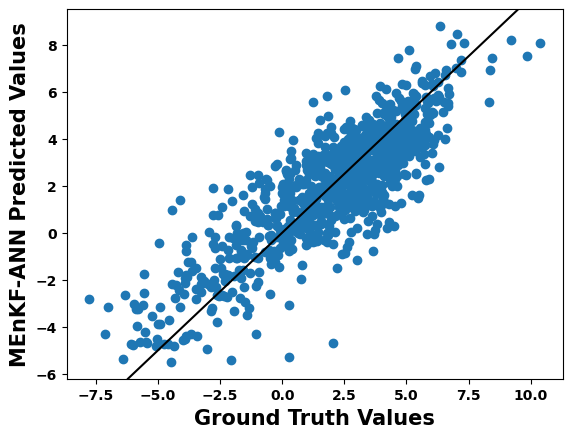

In [202]:
plt.scatter(y_test, averaged_preds_test)
plt.axline((0,0), slope = 1, c = "black")
plt.xlabel("Ground Truth Values", fontsize = 15, fontweight = "bold")
plt.ylabel("MEnKF-ANN Predicted Values", fontsize = 15, fontweight = "bold")
plt.xticks(fontsize = 10, fontweight = "bold")
plt.yticks(fontsize = 10, fontweight = "bold")
plt.show()

In [203]:
items = [best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r]

In [204]:
items_df = pd.DataFrame(items).T

In [205]:
items_df.columns = ['best_train_width', 'best_coverage_train', 'best_rmse_train', 'best_test_width', 'best_coverage_test', 'best_rmse_test', 'best_pearson_r']

In [206]:
items_df = items_df.T

In [207]:
items_df.columns = ["Value"]

In [208]:
items_df

,Value
best_train_width,11.992684
best_coverage_train,0.997200
best_rmse_train,1.451088
best_test_width,12.079126
best_coverage_test,0.999000
best_rmse_test,1.534123
best_pearson_r,0.839067


In [209]:
preds_test.shape

(218, 1000)

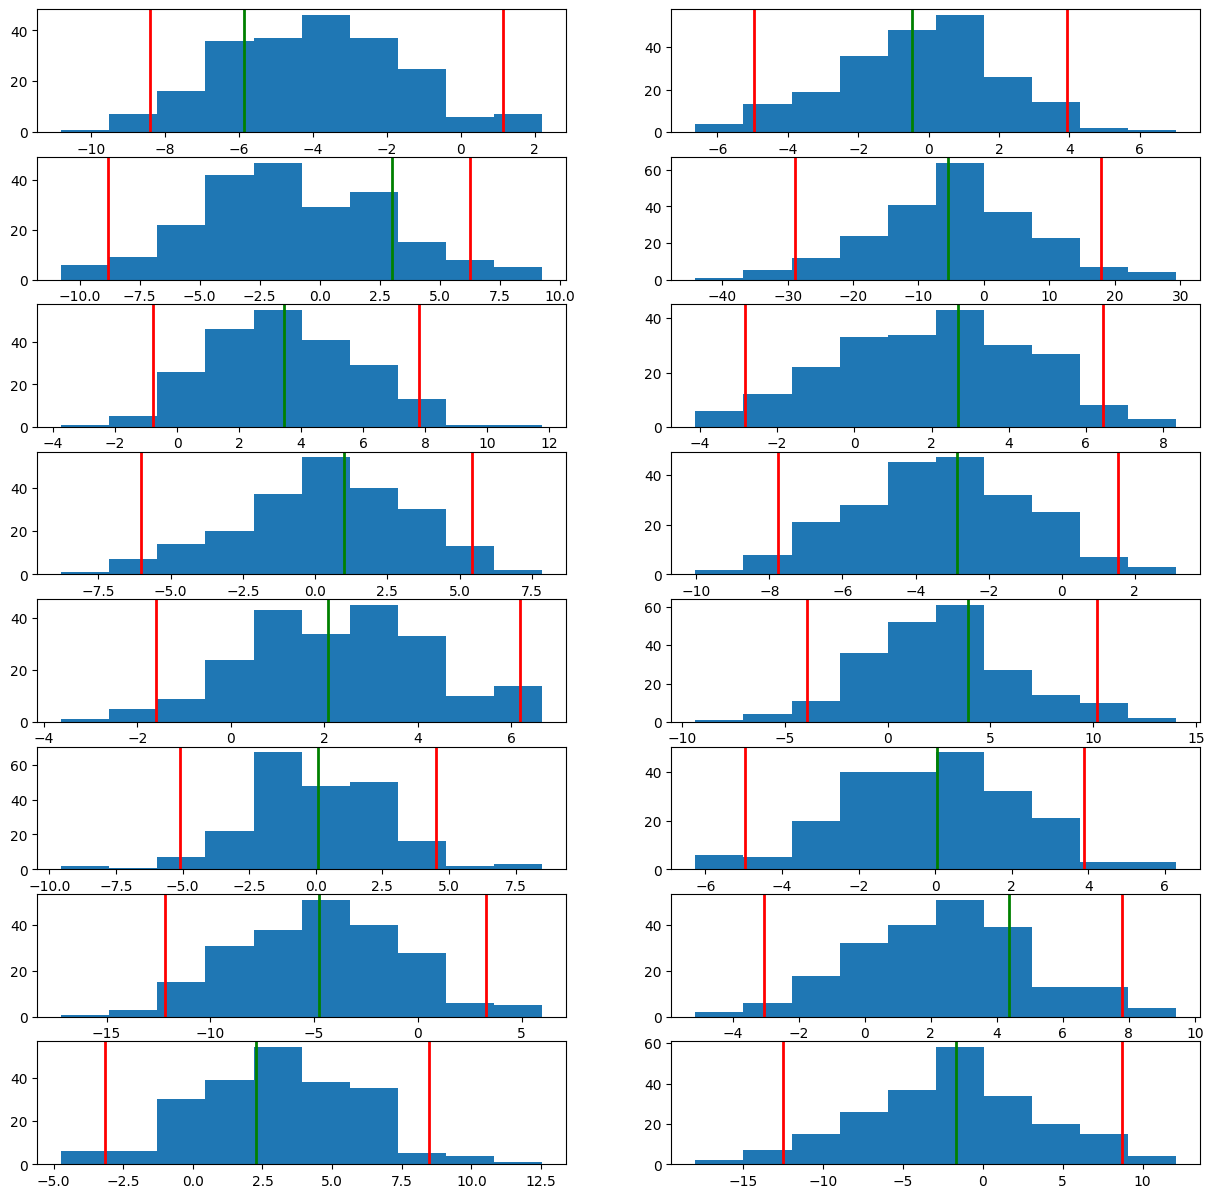

In [210]:
random_idx = random.sample(range(y_test.shape[0]), k = 16)
fig, axs = plt.subplots(8, 2,figsize=(15, 15))
axs = axs.ravel()
for idx, i in enumerate(random_idx):
    # print(counter)
    truth = y_test[i,:]
    preds = preds_test[:, i]
    percts = np.percentile(preds, axis = 0, q = (2.5, 97.5))
    lis = percts[0]
    uis = percts[1]
    
    
    axs[idx].hist(preds)
    axs[idx].axvline(truth, color='green', linewidth=2)
    axs[idx].axvline(lis, color='red', linewidth=2)
    axs[idx].axvline(uis, color='red', linewidth=2)

# plt.title
fig.savefig('gcn_cdr_pred_intervals.png', bbox_inches='tight')
plt.show()


In [211]:
# plt.hist(y_train)
# plt.show()

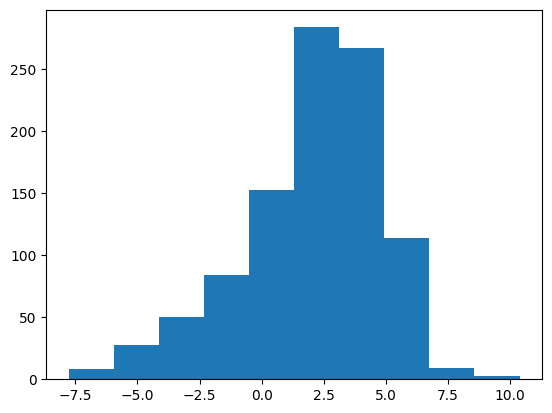

In [212]:
plt.hist(y_test)
plt.show()

In [ ]:
catch_overall = []

for idx in range(0,50): 
    best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r, _, _ = get_results(idx, var_weights = 2.0, var_weight_weights = 1.0, var_D = 1, inflation_factor =1, fudging_beta = beta(1,19), 
           fudging_var = 5e-3, epochs = 20)
    
    catch_overall.append([best_train_width, best_coverage_train, best_rmse_train, best_test_width, best_coverage_test, best_rmse_test, best_pearson_r])

epoch number is 0
Training Coverage, Widths, RMSE, and Pearson R
1.0 227.47573027469534 7.998454489604203 -0.2568727857976921
Testing Coverage, Widths, RMSE, and Pearson R
1.0 227.74428620523884 7.932309813202283 -0.29430480389995356
Patience is
0


epoch number is 1
Training Coverage, Widths, RMSE, and Pearson R
1.0 83.5626343041737 9.618680580357035 0.0820106514731444
Testing Coverage, Widths, RMSE, and Pearson R
1.0 84.044400987617 9.333994796414371 0.0985075388684067
Patience is
1


epoch number is 2
Training Coverage, Widths, RMSE, and Pearson R
0.8332 20.486753545800905 7.182217888738779 0.22728310801052806
Testing Coverage, Widths, RMSE, and Pearson R
0.843 20.601448153131177 7.125611797983572 0.19888091222689158
Patience is
0


epoch number is 3
Training Coverage, Widths, RMSE, and Pearson R
0.6164 6.004926436882632 3.3720623939756975 0.5391205554594074
Testing Coverage, Widths, RMSE, and Pearson R
0.613 6.027882880087652 3.3897843269620687 0.5216262329644802
Patience is
0


ep

In [ ]:
with open("..//Data//catch_overall_50_reps_c1.pickle", "wb") as f: 
    pickle.dump(catch_overall,f)

In [2]:
import pickle

In [3]:
with open("..//Data//catch_overall_50_reps_c1.pickle", "rb") as f: 
    catch_overall = pickle.load(f)

In [5]:
import pandas as pd

In [6]:
overall_df = pd.DataFrame(catch_overall).iloc[:,:7]
overall_df.mean()

0    7.169837
1    0.884808
2    1.464778
3    7.151291
4    0.874200
5    1.518174
6    0.843854
dtype: float64

In [7]:
overall_df.columns = ['best_train_width', 'best_coverage_train', 'best_rmse_train',
                      'best_test_width', 'best_coverage_test', 'best_rmse_test', 'best_pearson_r']

In [8]:
overall_df.mean()

best_train_width       7.169837
best_coverage_train    0.884808
best_rmse_train        1.464778
best_test_width        7.151291
best_coverage_test     0.874200
best_rmse_test         1.518174
best_pearson_r         0.843854
dtype: float64